# Deep Learning Nanodegree
## Convolutional Neural Networks
# Project: Write an Algorithm for a Dog Identification App
---
In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **IMPLEMENTATION** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code bock with a **TODO** statement. Please be sure to read the instructions carefully!

>**Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File->Download as->HTML(.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions taht you msut answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **Question X** header. Carefully read each question and provide thorough answers in the following text boxes that being with **Answer**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note**: Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains *optional* "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestion", you should include the code in this iPython notebook.

---
### Why we're here
In this notebook, you will make the first steps twoards developing an algorithm that could be used as part of a mobile or web app. At the end of this project, your code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed taht is most resembling. The image below displays potential sample output of your finished project(...but we expect taht each student's algorithm will behave differently).

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algoirthm that detects humans in an image will be different from the CNN that infers dog breed. There are many points of possible failure, and no perfect algorithm exists. Your imperfect solution will nonetheless create a fun user experience.

### The road ahead
We break the notebook into separate steps. Feel free to use the links below to naviage the notebook.
* [Step 0](#step0): Import datasets
* [Step 1](#step1): Detect humans
* [Step 2](#step2): Detect dogs
* [Step 3](#step3): Create a CNN to classify dog breeds (from scratch)
* [Step 4](step4): Use a CNN to classify dog breeds (using transfer learning)
* [Step 5](#step5): Create a CNN to classify dog breeds (using transfer learning)
* [Step 6](#step6): Write your algorithm
* [Step 7](#step7): Test your algorithm
---
<a id="step0"></a>
## Step 0: Import datasets
### Import dog dataset
In the code cell below, we import a dataset of dog images. We populate a few variables through the use of the load_files function from the scikit-learn library:
* `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
* `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels
* `dog_names` - list of string-valued dog breed names from translating labels

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation sets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data["filenames"])
    dog_targets = np_utils.to_categorical(np.array(data["target"]), 133)
    return dog_files, dog_targets

#load train, validation, and test datasets
train_files, train_targets = load_dataset("dogImages/train")
valid_files, valid_targets = load_dataset("dogImages/valid")
test_files, test_targets = load_dataset("dogImages/test")

#load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

#print dataset stats
print("There are {} total dog categories.".format(len(dog_names)))
print("There are {} total dog images.\n".format(len(np.hstack([train_files, valid_files, test_files]))))

print("There are {} training dog images.".format(len(train_files)))
print("There are {} validation dog images.".format(len(valid_files)))
print("There are {} testing dog images.".format(len(test_files)))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 testing dog images.


### Import human dataset
In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

#load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

#print dataset stats
print("There are {} total human images.".format(len(human_files)))

There are 13233 total human images.


Number of faces detected: 1


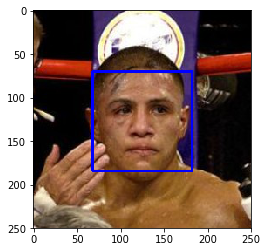

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#extract pre-trained face detector
face_cascade = cv2.CascadeClassifier("haarcascades/haarcascade_frontalface_alt.xml")

#load color(BGR) image
img = cv2.imread(human_files[3])
#convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#find faces in image
faces = face_cascade.detectMultiScale(gray)

#print number of faces detected in image
print("Number of faces detected: {}".format(len(faces)))

#get bounding box for each detected face
for (x,y,w,h) in faces:
    #add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

#converg BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#dispaly the image, along with the bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale. The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with 4 entries that specifies the bounding box of the detected face. The first 2 entries in the array(extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box. The last 2 entries in the array(extracted ehre as `w` and `h` specify the width and height of the box.

### Write a human face detector
We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise. This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below:

In [5]:
def face_detector(img_path):
    """This function returns True if a face is detected in the
    image stored at img_path and False otherwise."""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return 0 < len(faces)

### (IMPLEMENTATION) Asses the human face detector
**Question 1**: Use the code cell below to test the performance of the `face_detector` function.
* What percentage of the first 100 images in `human_files` have a detected human face?
* What percentage of the first 100 images in `dog_files` have a detected human face?

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. You will see that our algorithm falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays as `human_files_short` and `dog_files_short`.

**Answer**:

In the first 100 images of `human_files`, `face_detector()` predicted a human face in 98% of the images.

In the first 100 images of `dog_files`, `face_detector()` predicted a human face in 11% of the images.

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

#TODO: Test the performance of the face_detector algorithm on
#the images in human_files_short and dog_files_short
face_detector_human_accuracy = 0
for hf in human_files_short:
    if face_detector(hf):
        face_detector_human_accuracy += 1
face_detector_human_accuracy = face_detector_human_accuracy / len(human_files_short) * 100
print("Percentage of human faces in human_files_short: {}%"
      .format(face_detector_human_accuracy))

face_detector_dog_accuracy = 0
for df in dog_files_short:
    if face_detector(df):
        face_detector_dog_accuracy += 1
face_detector_dog_accuracy = face_detector_dog_accuracy /  len(dog_files_short) * 100
print("Percentage of human faces in dog_files_short: {}%"
      .format(face_detector_dog_accuracy))


Percentage of human faces in human_files_short: 98.0%
Percentage of human faces in dog_files_short: 11.0%


**Question 2**: This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we reisk having unnecessarily frustrated users!). In your opinion, is this a reasonable expectation to pose to the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

**Answer**: Although facial recognition is useful for applications like Facebook (where users pose for a picture and often are staring straight at the camera, and later Facebook makes it easy to tag your friends by recognizing their faces and allowing you to confirm), it has many use cases where the face needing to be recognized will not come with perfect conditions. For example, if the NSA were monitoring cameras looking for a dangerous criminal and they picked up a match on a subway camera, if this person is a fugitive on the run they're most likely hiding their face.

Because of this, for general software it's most likely *not* an acceptable expectation to force users to only use "picture-perfect" images, but for commercial software applications where people are often looking at the camera it *may be* an acceptable requirement.

In order for a neural network to recognize faces that are not clearly presented, it will most likely require a more varied training set. Obviously adding in new images of faces viewed from the side or *odd* angles will help the model learn to recognize from varied angles.

However, using the current dataset, a randomly selected training image X<sub>i</sub> could provide greater information than it already is. By creating duplicates of X<sub>i</sub> in the training set and either rotating them about their center *or* flipping the images horizontally and/or vertically, we add new training data points to the model without going out to find new images.

---
We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :). Please use the code cell below to design and test your own face detection algorithm. If you decide to pursue this *optional* task, report performance on each of the datasets.

In [7]:
#(Optional) TODO: Report the performances of another face
#detection algorithm on the LFW dataset.
#Feel free to use as many code cells as needed.

## Step 2: Detect dogs
In this section, we use pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

#define ResNet50 model
ResNet50_model = ResNet50(weights="imagenet")

### Pre-process the data
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape 

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is 224 x 224 pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. in this case, since we are working with color images, each image has 3 channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    #loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    #convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    #convert 3D tensor to 4D tensor with shape (1, 224, 224, 3)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making predictions with ResNet-50
Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as [103.939, 116.779, 123.68] and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function `preprocess_input`. If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the `predict` method, which returns an array whose *i*-th entry is the model's predicted probabilitiy that the image belongs to the *i*-th ImageNet category. This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    #returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a dog detector
While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice taht the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from "Chihuahua" to "Mexican hairless". Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the ResNet50_predict_labels function above returns a valube between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
def dog_detector(img_path):
    """Returns True if a dog is detected in the image stored at
    img_path and False otherwise."""
    prediction = ResNet50_predict_labels(img_path)
    return 151 <= prediction <= 268

### (IMPLEMENTATION) Asses the Dog Detector
**Question 3**: Use the code cell below to test the performance of your `dog_detector` function.
* What percentage of the images in `human_files_short` have a detected dog?
* What percentage of the images in `dog_files_short` have a detected dog?

**Answer**:

For `human_files_short`, the ResNet-50 model pre-trained on ImageNet detected a dog in 1% of the images. 

For `dog_files_short`, the ResNet-50 model pre-trained on ImageNet detected a dog in 100% of the images.

In [12]:
#TODO: Test the performance of the dog_detector functoin
#on the images in human_files_short and dog_files_short
dd_hfs_percent = 0
for h in human_files_short:
    if dog_detector(h):
        dd_hfs_percent += 1
dd_hfs_percent = dd_hfs_percent / len(human_files_short) * 100
print("Percent of human_files_short w/ detected dog: {}%".format(dd_hfs_percent))

dd_dfs_percent = 0
for d in dog_files_short:
    if dog_detector(d):
        dd_dfs_percent += 1
dd_dfs_percent = dd_dfs_percent / len(dog_files_short) * 100
print("Percent of dog_files_short w/ detected dog: {}%".format(dd_dfs_percent))

Percent of human_files_short w/ detected dog: 1.0%
Percent of dog_files_short w/ detected dog: 100.0%


## Step 3: Create a CNN to classify dog breeds (from scratch)
Now that we have functions for detecting humans and dogs in images, we need a way to predict the breed from iamges. In this step, you will create a CNN that classifies dog breeds. You must create your CNN from *scratch* (so, you can't use transfer learning yet!), and you must attain a test accuracy of at least 1%. In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers! More parameters means longer training, which means you are most likely to need a GPU to accelerate the training process. Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train.

We mention that the task of assigning breeds to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black. Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

Remember that the practice is far ahead of the theory in deep learning. Experiment with many different architectures, and trust your intuition. And, of course, have fun!

### Pre-process the data
We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype("float32")/255
valid_tensors = paths_to_tensor(valid_files).astype("float32")/255
test_tensors = paths_to_tensor(test_files).astype("float32")/255

100%|██████████| 836/836 [00:06<00:00, 127.98it/s]


### (IMPLEMENTATION) Model architecture
Create a CNN to classify dog breed. At the end of your code cell block, summarize the layers of your model by executing `model.summary()`.

We have imported some Python modules to get you started, but feel free to import as many modules as you need. If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)

**Question 4**: Outline the steps you took to get your final CNN architecture and your reasoning at each step. If you chose the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

**Answer**: I figured I'd start out by implementing the hinted model because setting up the AWS environment almost took a week and I still don't trust that the GPU requirements file installed correctly on the ubuntu instance (that `requirements/` was modified 2 times in 5 days after countless complaints on the forum that I'm assuming were taken as "the students are just not good at linux").

So to assemble the hinted model from the summary previewed in the image, I opened up one of the `.ipynb` files from lesson 3.2 to figure out the syntax to add Conv2D and MaxPooling2D layers from keras (because it's been almost a week since I could do any deep learning remember). I got the first convolutional layer added, added in the MaxPooling layer, and executed `model.summary()` to ensure the output was looking *similar*. I continued to do so up until the addition of the GlobalAveragePooling2D layer.

The summaries were matching, but in the first iteration I specified `padding="same"` and noticed a differential of `-1` in the cascading output shapes between any given MaxPooling2D<sub>i-1</sub> and Conv2D<sub>i</sub> in the hinted image (which my model currently didn't have), so I went back to the lesson 3.2.13-3.2.13 to look for the other padding option: `padding="valid"`.

*Why would this CNN architecture work well for the image classification task?*

As learned in the Convolutional Neural Networks lesson, the convolutional layers deepest in the network recognize the most detailed patterns, while earlier convolutional layers closer to the input mouth detect very primitive details. Seeing as how dog breed classification is a difficult problem (certain breeds could easily be misclassified based on similarities shared between breeds `breed<sub>A</sub>`, `breed<sub>B</sub>`, `breed<sub>C</sub>`), it makes sense that a great level of detail recognition will be required. A neural network consisting of 3 convolutional layers is a great starting point, but it is likely that adding additional convolutional layers could increase detail/pattern recognition to distinguish breeds.

Additionally, the hinted model included a global average pooling layer. Introducting a pooling layer at the end of the stack of convolutional layers significantly reduces the dimensionality of the feature maps computed from the previous convolutional layers. The presence of this layer will decrease the training time of the model **significantly** in comparison to the model where the pooling layer is absent *as the number of convolutional layers in the neural network increases*.

Finally, the last layer in the hinted model is a dense layer containing the same number of nodes as there are classes for the dog breed dataset: 133 nodes for 133 breeds. This dense layer's activation function is a softmax because we need to estimate the probability of a data point X<sub>i</sub> being *any* breed, with the node containing the highest value on the interval [0, 1] as the neural network's predicted target breed.

However, the proposed *post-convolutional* stack of layers only includes a single dense layer without any dropout layers to prevent overfitting. Because our 1 and only dense layer is used with the softmax activation function, it wouldn't make sense to dropout our target predictions (a dropout should not be used in conjunction with only 1 dense layer when the dense layer produces the target). However, if we decide to add further dense layers in the future to train a higher performing model, adding dropout layers in between the dense layers would be a wise choice so that our model does not *memorize* our training data. The convolutional neural network needs to perform well on the validation and testing sets (which it does not take into account for weight adjustment).

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

#TODO: Define your architecture
model = Sequential()
model.add(Conv2D(
    filters=16, kernel_size=2, padding="valid",
    activation="relu", input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(
    filters=32, kernel_size=2, padding="valid",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(
    filters=64, kernel_size=2, padding="valid",
    activation="relu"
))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the model

In [15]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### (IMPLEMENTATION) Train the model
Train your model in the code cell below. Use model checkpointing to save the model that attains the best validation loss.

In [16]:
output_file = 'saved_models/weights.best.from_scratch.hdf5'
from keras.callbacks import ModelCheckpoint

In [17]:
#train
checkpointer = ModelCheckpoint(
    filepath=output_file,
    verbose=1,
    save_best_only=True
)
hist = model.fit(
    train_tensors,
    train_targets,
    batch_size=32,
    epochs=5,
    validation_data=(valid_tensors, valid_targets),
    callbacks=[checkpointer],
    verbose=2,
    shuffle=True
)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 4.86848, saving model to saved_models/weights.best.from_scratch.hdf5
 - 194s - loss: 4.8837 - acc: 0.0078 - val_loss: 4.8685 - val_acc: 0.0108
Epoch 2/5
Epoch 00002: val_loss improved from 4.86848 to 4.84122, saving model to saved_models/weights.best.from_scratch.hdf5
 - 194s - loss: 4.8592 - acc: 0.0121 - val_loss: 4.8412 - val_acc: 0.0180
Epoch 3/5
Epoch 00003: val_loss improved from 4.84122 to 4.81251, saving model to saved_models/weights.best.from_scratch.hdf5
 - 194s - loss: 4.8183 - acc: 0.0169 - val_loss: 4.8125 - val_acc: 0.0216
Epoch 4/5
Epoch 00004: val_loss improved from 4.81251 to 4.78388, saving model to saved_models/weights.best.from_scratch.hdf5
 - 194s - loss: 4.7840 - acc: 0.0207 - val_loss: 4.7839 - val_acc: 0.0180
Epoch 5/5
Epoch 00005: val_loss improved from 4.78388 to 4.76650, saving model to saved_models/weights.best.from_scratch.hdf5
 - 194s - loss: 4.7603 - acc: 0

### Load the model with the best validation loss

In [18]:
model.load_weights(output_file)

### Test the model
Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 1%.

In [19]:
#get index of the predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(
    np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
#report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions) == 
                          np.argmax(test_targets, axis=1)) / len(dog_breed_predictions)
print("Test accuracy: %.4f%%" % test_accuracy)

Test accuracy: 1.6746%


## Step 4: Use a CNN to classify dog breeds
To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning. In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain bottleneck features

In [20]:
bottleneck_features = np.load("bottleneck_features/DogVGG16Data.npz")
train_VGG16 = bottleneck_features["train"]
valid_VGG16 = bottleneck_features["valid"]
test_VGG16 = bottleneck_features["test"]

### Model architecture
The model uses the pre-trainedVGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input ot our model. We only ad a global average pooling layer and a fully connected layer, wher the latter contians one node for each dog category and is equiped with a softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(
    input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation="softmax"))
VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [22]:
VGG16_model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

### Train the model

In [23]:
output_file01 = "saved_models/weights.best.VGG16.hdf5"
checkpointer = ModelCheckpoint(
    filepath=output_file01,
    verbose=1,
    save_best_only=True)

VGG16_model.fit(
    train_VGG16,
    train_targets,
    validation_data=(valid_VGG16, valid_targets),
    epochs=20,
    batch_size=20,
    callbacks=[checkpointer],
    verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s 218us/step - loss: 12.3552 - acc: 0.1199 - val_loss: 10.6849 - val_acc: 0.2096
Epoch 2/20
6680/6680 [==============================] - 1s 164us/step - loss: 10.1176 - acc: 0.2849 - val_loss: 10.1045 - val_acc: 0.2766
Epoch 3/20
6680/6680 [==============================] - 1s 163us/step - loss: 9.6525 - acc: 0.3433 - val_loss: 9.8966 - val_acc: 0.3006
Epoch 4/20
6680/6680 [==============================] - 1s 163us/step - loss: 9.3899 - acc: 0.3757 - val_loss: 9.8066 - val_acc: 0.3090
Epoch 5/20
6680/6680 [==============================] - 1s 164us/step - loss: 9.2581 - acc: 0.3940 - val_loss: 9.6761 - val_acc: 0.3150
Epoch 6/20
6680/6680 [==============================] - 1s 164us/step - loss: 9.1115 - acc: 0.4075 - val_loss: 9.5078 - val_acc: 0.3341
Epoch 7/20
6680/6680 [==============================] - 1s 164us/step - loss: 8.8692 - acc: 0.4226 - val_loss: 9.3107 - val_acc: 0.35

### Load the model with the best validation loss

In [24]:
VGG16_model.load_weights(output_file01)

### Test the model
Now we can use the CNN to test how well it identifies breed within our test dataset of dog images. We print the test accuracy below.

In [25]:
#get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(
    np.expand_dims(feature, axis=0))) for feature in test_VGG16]

#report test accuracy
test_accuracy = 100*np.sum(
    np.array(VGG16_predictions) == np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print("Test accuracy: %.4f%%" % test_accuracy)

Test accuracy: 43.3014%


### Predict dog breed with the model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    #extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    #obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    #return dog breed that is predicted
    return dog_names[np.argmax(predicted_vector)]

---
## Step 5: Create a CNN to classify dog breeds (using transfer learning)
You will now use transfer learning to create a CNN that can identify dog breeds from images. Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features. In this section, you must use the bottleneck features from a different pre-trained model. To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
* [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
* [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
* [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
* [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}` in the above filename can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`. Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder.

### (IMPLEMENTATION) Obtain bottleneck features
In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load("bottleneck_features/Dog{network}Data.npz)
    train_{network} = bottleneck_features["train"]
    valid_{network} = bottleneck_features["valid"]
    test_{network} = bottleneck_features["test"]

In [27]:
bf_inception = np.load("bottleneck_features/DogInceptionV3Data.npz")

In [28]:
train_inception = bf_inception["train"]
valid_inception = bf_inception["valid"]
test_inception = bf_inception["test"]

### (IMPLEMENTATION) Model architecture
Create a CNN to classify dog breed. At the end of your code cell block, summarize they layers of your model by executing the line:

    <your model's name>.summary()
    
**Quetions 5**: Outline the steps you took to get your final CNN architecture nad your reasoning at each step. Describe why you think the architecture is suitable for the current problem.

**Answer**: Originally I modeled the architecture off of the model from Step 4 where VGG16 was used for transfer learning. The pooling layer is added to reduce the dimensionality from the convolutional layers. The 133 node dense layer with a softmax activation function uses the feature detection from the transfered Inception convolutional layers in conjunction with the pooling layer to create a probability vector, where the index with the highest value (bound on the interval [0, 1]) is the new model's prediction.

In [29]:
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
Inception_model.add(Dense(133, activation="softmax"))

Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [30]:
Inception_model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

### Train the model

In [31]:
output_file02 = "saved_models/weights.best.Inception.hdf5"

In [32]:
checkpointer = ModelCheckpoint(
    filepath=output_file02,
    verbose=1,
    save_best_only=True)

Inception_model.fit(
    train_inception,
    train_targets,
    validation_data=(valid_inception, valid_targets),
    epochs=20,
    batch_size=20,
    callbacks=[checkpointer],
    verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 320us/step - loss: 1.1647 - acc: 0.7006 - val_loss: 0.6341 - val_acc: 0.8096
Epoch 2/20
6680/6680 [==============================] - 2s 262us/step - loss: 0.4720 - acc: 0.8542 - val_loss: 0.6187 - val_acc: 0.8383
Epoch 3/20
6680/6680 [==============================] - 2s 262us/step - loss: 0.3696 - acc: 0.8873 - val_loss: 0.6143 - val_acc: 0.8455
Epoch 4/20
6680/6680 [==============================] - 2s 260us/step - loss: 0.2986 - acc: 0.9081 - val_loss: 0.6619 - val_acc: 0.8515
Epoch 5/20
6680/6680 [==============================] - 2s 259us/step - loss: 0.2401 - acc: 0.9244 - val_loss: 0.7309 - val_acc: 0.8467
Epoch 6/20
6680/6680 [==============================] - 2s 260us/step - loss: 0.2020 - acc: 0.9394 - val_loss: 0.6666 - val_acc: 0.8527
Epoch 7/20
6680/6680 [==============================] - 2s 262us/step - loss: 0.1721 - acc: 0.9472 - val_loss: 0.7671 - val_acc: 0.8539
E

### (IMPLEMENTATION) Load the model with th best validation loss

In [33]:
Inception_model.load_weights(output_file02)

### (IMPLEMENTATION) Test the model
Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [34]:
#get index of predicted dog breed for each image in test set
Inception_predictions = [np.argmax(Inception_model.predict(
    np.expand_dims(feature, axis=0))) for feature in test_inception]

#report test accuracy
inception_test_accuracy = 100*np.sum(np.array(Inception_predictions)==
                                    np.argmax(test_targets, axis=1))/len(Inception_predictions)
print("Test accuracy: %.4f%%" % inception_test_accuracy)

Test accuracy: 81.6986%


### (IMPLEMENTATION) Predict dog breed with model
Write a function that takes an image path as input and returns the dog breed that is predicted by your model.

Similar to the analogous function in Step 4, your function should have 3 steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector. Note that argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}` should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [35]:
def Inception_predict_breed(img_path):
    #extract bottleneck features
    bottleneck_features = extract_InceptionV3(path_to_tensor(img_path))
    #obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_features)
    #return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
## Step 6: Write your algorithm
Write an algorithm that accepts a file path to an image and first determines whether or not the image contains a human, dog, or neither. Then,
* If a **dog** is detected in the image, return the predicted breed.
* If a **human** is detected in the image, return the resembling dog breed.
* If **neither** is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above. You are **required** to use your CNN from Step 5 to predict the dog breed.

Some sample output for our algorithm is provided below, but feel free to design your own user experiance!

### (IMPLEMENTATION) Write your algorithm

In [36]:
def human_or_dog(img_path):
    """Detects whether a human or dog is in an image. If either
    is detected, the predicted breed is output."""
    greeting = "hello, "
    is_human = False
    is_unknown = False
    breed = ""
    
    #Test if a dog or human is detected
    if dog_detector(img_path):
        greeting += "dog!"
    elif face_detector(img_path):
        greeting += "human!"
        is_human = True
    else:
        #Handle error
        greeting = "Error: No dog or human detected."
        is_unknown = True
    
    #If dog or human was detected, predict breed
    if not is_unknown:
        breed = Inception_predict_breed(img_path)
    
    #Output
    print(greeting)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    if not is_unknown:
        print("You look like a ... {}!".format(breed))

---
## Step 7: Test your algorithm
In this section, you will take your new algorithm for a spin! What kind of dog does the algorithm think that **you** look like? If you have a dog, does it predict your dog's breed accurately? If you have a cat, does it mistakenly think your cat is a dog?

### (IMPLEMENTATION) Test your algorithm on sample images!

Test your algorithm on at least six images on your computer. Feel free to use any images you like. Use at least 2 human and dog images.

**Question 6**: Is the output better than you expected? Worse? Provide at least 3 possible points of improvement for your algorithm.

**Answer**: The algorithm performs very well. It classifies humans and dogs correctly, but it can also detect when neither is present. Even when given hideous dogs, it classifies them (probably a misclassification) to a breed the dog strongly resembles.

To improve the algorithm, I'd probably start by adding in 1-2 dense layers with corresponding dropout layers in between to see if we could get the `Inception_model`'s into the 85-90% range.

Although the ugly dogs are classified as canine, their breeds are most likely incorrect (not much to cross reference actual breeds from given that they're memes). To alleviate this, we could try finding uncommon looking dogs which have known breeds and pass them into `Inception_model` for training **after** passing in more dense layers. However, this is also falling into the realm of outlier detection.

Lastly, the algorithm will most likely perform poorly if images of dogs are passed in without their faces. To train the dataset to place heavier classification on canine body feature recognition, we could modify the current training set by randomly creating copies of current dog images, where the duplicates would be cropped such that the faces are out of frame.

In [37]:
step7_imgs = np.array(glob("step7_images/*"))

hello, dog!
You look like a ... Affenpinscher!


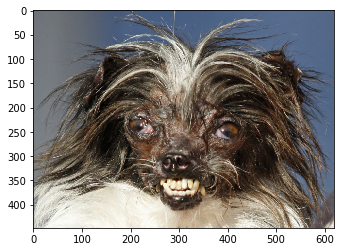

In [38]:
human_or_dog(step7_imgs[0])

hello, dog!
You look like a ... Brittany!


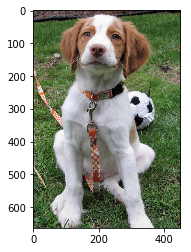

In [39]:
human_or_dog(step7_imgs[1])

Error: No dog or human detected.


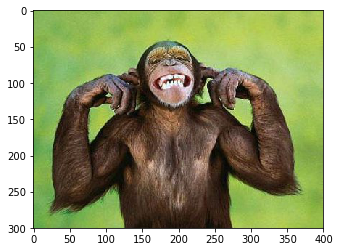

In [40]:
human_or_dog(step7_imgs[2])

hello, dog!
You look like a ... Chinese_shar-pei!


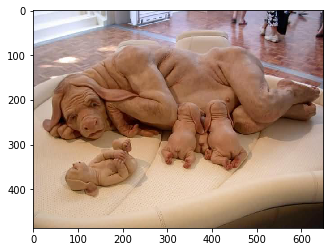

In [41]:
human_or_dog(step7_imgs[3])

hello, human!
You look like a ... Lowchen!


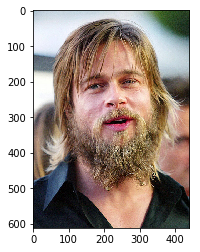

In [42]:
human_or_dog(step7_imgs[4])

hello, human!
You look like a ... Chinese_crested!


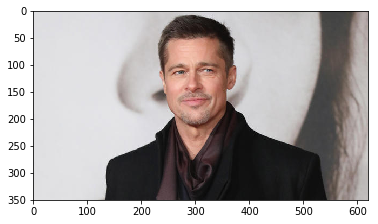

In [43]:
human_or_dog(step7_imgs[5])

hello, dog!
You look like a ... Australian_cattle_dog!


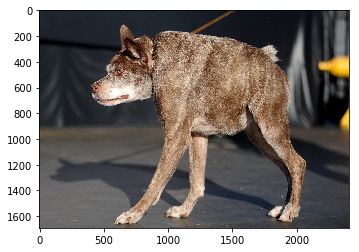

In [44]:
human_or_dog(step7_imgs[6])

Error: No dog or human detected.


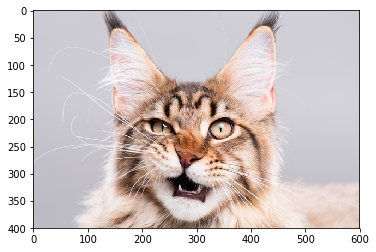

In [45]:
human_or_dog(step7_imgs[7])

Error: No dog or human detected.


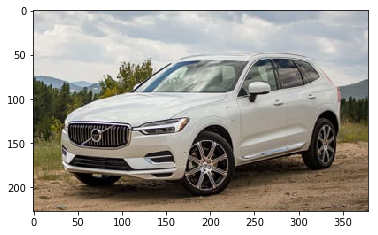

In [46]:
human_or_dog(step7_imgs[8])